In [1]:
from ANI1_release.ANI1_release.readers.lib import pyanitools as pya
from sklearn.model_selection import train_test_split


import torch 
from torch import nn
import numpy as np
import torchani


from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# 2) Network  construction  and  workflow  development.  At  this  point  you  should  have  a working code that can train the network, demonstrated on small subset of the data. 

In [2]:
from ANI1_release.ANI1_release.readers.lib.pyanitools import anidataloader
data = anidataloader("ANI1_release/ANI1_release/ani_gdb_s01.h5")
data_iter = data.__iter__()

mols = next(data_iter)
# Extract the data
P = mols['path']
X = mols['coordinates']
E = mols['energies']
S = mols['species']
sm = mols['smiles']

# Print the data
print("Path:   ", P)
print("  Smiles:      ","".join(sm))
print("  Symbols:     ", S)
print("  Coordinates: ", X.shape)
print("  Energies:    ", E.shape, "\n")


    
    
   

data_iter = data.__iter__()
count=0
count_conf =0
for mol in data_iter:
    count+=1
    count_conf += len(mol['energies'])
print(count)
print(count_conf)




Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

3
10800


# customized aev function used to calculate aev of each molecule

In [3]:
def calc_aev(X,S):
    Rcr=5.2
    Rca=3.5
    EtaR=torch.tensor([16],dtype=torch.float)
    ShfR=torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250],dtype=torch.float)
    EtaA=torch.tensor([8],dtype=torch.float)
    Zeta=torch.tensor([32],dtype=torch.float)
    ShfA=torch.tensor([0.900000,1.550000,2.200000,2.850000],dtype=torch.float)
    ShfZ=torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243],dtype=torch.float)
    num_species=4
    X=torch.tensor(X,dtype=torch.float)
    mapping={"H":0, "C":1, "N":2, "O":3}
    
    
    elements = np.array([mapping[atom] for atom in S])
    elements2=torch.tensor(elements,dtype=torch.long).repeat(X.shape[0],1)
    
    aevs_X=torchani.AEVComputer(Rcr,Rca,EtaR,ShfR,EtaA,Zeta,ShfA,ShfZ,num_species)
    
    
    
    aev_calc=aevs_X((elements2,X))
    molecule_aev=aev_calc[1]
    molecule_aev_shape=aev_calc[1].shape
    
    
    return molecule_aev,molecule_aev_shape,S

In [4]:
import ANI1_release.ANI1_release.readers.lib.pyanitools as pya
seq=list()

# Set the HDF5 file containing the data
hdf5file = 'ANI1_release/ANI1_release/ani_gdb_s01.h5'

# Construct the data loader class
adl = pya.anidataloader(hdf5file)

# Print the species of the data set one by one
for data in adl:

    # Extract the data
    P = data['path']
    X = data['coordinates']
    E = data['energies']
    S = data['species']
    sm = data['smiles']
    
    # Print the data
    print("Path:   ", P)
    print("  Smiles:      ","".join(sm))
    print("  Symbols:     ", S)
    print("  Coordinates: ", X.shape)
    print("  Energies:    ", E.shape, "\n")
    



    seq.append(data)
    
    
    
    

list_coords=[]
for i in range(count):
    list_coords.append(seq[i]['coordinates'])


list_species=[]
for i in range(count):
    list_species.append(seq[i]['species'])


list_energies=[]
for i in range(count):
    list_energies.append(seq[i]['energies'])
    

list_species_coords_=zip(list_coords,list_species)
list_aevs_=[calc_aev(X,S) for X,S in list_species_coords_]

for i in range(count):
    print(list_aevs_[i][0].shape)


adl.cleanup()

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

Path:    /gdb11_s01/gdb11_s01-1
  Smiles:       [H]N([H])[H]
  Symbols:      ['N', 'H', 'H', 'H']
  Coordinates:  (3600, 4, 3)
  Energies:     (3600,) 

Path:    /gdb11_s01/gdb11_s01-2
  Smiles:       [H]O[H]
  Symbols:      ['O', 'H', 'H']
  Coordinates:  (1800, 3, 3)
  Energies:     (1800,) 



/home/joyce/miniconda3/lib/python3.9/site-packages/torchani/aev.py:236: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pair_sizes = counts * (counts - 1) // 2


torch.Size([5400, 5, 384])
torch.Size([3600, 4, 384])
torch.Size([1800, 3, 384])


# data generator that batches into a molecules'confirmations 

In [5]:
def data_gen(X,y, batchsize):
    '''
    Generator for data
    '''
    if len(X)//batchsize == 0:
        return X[:batchsize],y[:batchsize]

    for i in range(len(X)//batchsize):
        yield X[i*batchsize:(i+1)*batchsize],y[i*batchsize:(i+1)*batchsize]
    i+=1
    yield X[i*batchsize:],y[i*batchsize:]
    

In [6]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

# trainer class takes X's that correspond to the molecules' coordinates and molecules actual energy, atom_types is a list of lists of atoms that make up that individual molecule. Loss is collected for each molecule then added iteratively.

In [7]:
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs, test_inputs,test_outputs,atom_types,draw_curve=False,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        """
        
        train_gen_coords_energies=[]
        for i in range(count):
            train_gen=data_gen(inputs[i],outputs[i],self.batch_size)
            train_gen_coords_energies.append(next(train_gen))
            
        train_gen_coords=[]
        for i in range(count):
            train_gen_coords.append(train_gen_coords_energies[i][0])
            
        train_gen_energies=[]
        for i in range(count):
            train_gen_energies.append(train_gen_coords_energies[i][1])
            
        
        list_species_coords=zip(train_gen_coords,atom_types)
        list_aevs=[calc_aev(X,S) for X,S in list_species_coords]
        


        
        losses = []
        val_losses = []
        test_losses=[]
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        lowest_test_loss = np.inf

        

        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
    
            epoch_loss = 0
            epoch_acc = 0

            for i in range(len(list_aevs)):
                batch_predictions = self.model(list_aevs[i][0],list_aevs[i][2])


                batch_importance = len(train_gen_coords_energies[i][1]) / len(outputs)
                loss = nn.MSELoss()(batch_predictions, torch.tensor(train_gen_energies[i],dtype=torch.float,))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().cpu().item() * batch_importance                
            
            val_loss = self.evaluate(val_inputs, val_outputs, atom_types,print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f " % (val_loss))
                
            losses.append(epoch_loss)
            val_losses.append(val_loss)
            
            test_loss=self.evaluate(test_inputs, test_outputs, atom_types,print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Test_loss: %.3f " % (test_loss))
                
            test_losses.append(test_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
                    
            if early_stop:
                if val_loss < lowest_test_loss:
                    lowest_test_loss = test_loss
                    weights = self.model.state_dict()
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        
        if early_stop:
            self.model.load_state_dict(weights)


        return {"losses": losses,  "val_losses": val_losses, "test_losses": test_losses}
        
    def evaluate(self, inputs, outputs, atom_types,print_acc=True):
        gen_coords_energies=[]
        for i in range(count):
            gen=data_gen(inputs[i],outputs[i],self.batch_size)
            gen_coords_energies.append(next(gen))
            
        gen_coords=[]
        for i in range(count):
            gen_coords.append(gen_coords_energies[i][0])
            
        gen_energies=[]
        for i in range(count):
            gen_energies.append(gen_coords_energies[i][1])
            
        self.model.eval()
            
        
        list_species_coords=zip(gen_coords,atom_types)
        list_aevs=[calc_aev(X,S) for X,S in list_species_coords]
        

        losses = 0

        for i in range(len(list_aevs)):
            
            batch_importance = len(gen_coords_energies[i][1]) / len(outputs)
            
            with torch.no_grad():
                batch_predictions = self.model(list_aevs[i][0],list_aevs[i][2])
                loss = nn.MSELoss()(batch_predictions, torch.tensor(gen_energies[i],dtype=torch.float,))
                

                
            losses += loss.detach().cpu().item() * batch_importance

        return losses

# neural network that takes atom type iteratively than predicts an energy for each molecule

In [8]:
class ANI(nn.Module):
    def __init__(self):
        super().__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub(nn.Sequential(nn.Linear(384,300), nn.CELU(0.1), nn.Linear(300,10))), 
                                       "H": ANI_sub(nn.Sequential(nn.Linear(384,300),nn.CELU(0.1),  nn.Linear(300,10))),
                                       "N": ANI_sub(nn.Sequential(nn.Linear(384,300),  nn.CELU(0.1),nn.Linear(300,10))), 
                                       "O": ANI_sub(nn.Sequential(nn.Linear(384,300),nn.CELU(0.1),  nn.Linear(300,10)))})

    def forward(self, aevs, atom_types):
        num_conf, num_atoms, aev_vec=aevs.shape
        atomic_energies=torch.empty((num_conf, 0),dtype=torch.float)
        aev_shape=aevs.reshape(num_atoms, num_conf, aev_vec)
        for i in range(len(atom_types)):
            atom=self.sub_nets[atom_types[i]](aev_shape[i])
#             atom=torch.tensor(atom,dtype=torch.float)

            atomic_energies=torch.cat((atomic_energies,atom),1,)
#             print('tot eng OUT: {}'.format(atomic_energies))
#             print('tot eng: {}'.format(atomic_energies.requires_grad))
    
    
    
        
        total_energies = torch.sum(atomic_energies,dim=-1,dtype=torch.float,)
#         print('tot eng OUT: {}'.format(total_energies))
#         print('tot eng: {}'.format(total_energies.requires_grad))

        return total_energies
                            
class ANI_sub(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        self.layers= architecture
        
    def forward(self, aev):
        atomic_energy = self.layers(aev)
        return atomic_energy

# train_test_split for tests, validation, and train tests for each molecule that is appended to each respective lists 

In [9]:
train_X=[]
train_y=[]
test_X=[]
test_y=[]
val_X=[]
val_y=[]
for i in range(count):
    train_Xs, test_Xs, train_ys, test_ys = train_test_split(list_coords[i],list_energies[i],test_size=0.2,random_state=42)
    train_Xs, val_Xs, train_ys, val_ys = train_test_split(train_Xs,train_ys,test_size=0.2,random_state=42)
    
    train_X.append(train_Xs)
    train_y.append(train_ys)
    test_X.append(test_Xs)
    test_y.append(test_ys)
    val_X.append(val_Xs)
    val_y.append(val_ys)




# trainer class running to measure loss using MSE 

In [10]:
from torchsummary import summary
model=ANI()
summary(model)
trainer = Trainer(model, 'adam', 1e-2, 50, 60) 

Layer (type:depth-idx)                   Param #
├─ModuleDict: 1-1                        --
|    └─ANI_sub: 2-1                      --
|    |    └─Sequential: 3-1              118,510
|    └─ANI_sub: 2-2                      --
|    |    └─Sequential: 3-2              118,510
|    └─ANI_sub: 2-3                      --
|    |    └─Sequential: 3-3              118,510
|    └─ANI_sub: 2-4                      --
|    |    └─Sequential: 3-4              118,510
Total params: 474,040
Trainable params: 474,040
Non-trainable params: 0


  6%|██▋                                         | 3/50 [00:00<00:07,  6.35it/s]

Epoch 1/50 - Loss: 190604.563
              Val_loss: 110693.057 
Epoch 1/50 - Loss: 190604.563
              Test_loss: 110101.700 


 26%|███████████▏                               | 13/50 [00:01<00:02, 12.82it/s]

Epoch 11/50 - Loss: 669.072
              Val_loss: 557.783 
Epoch 11/50 - Loss: 669.072
              Test_loss: 501.612 


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 15.31it/s]

Epoch 21/50 - Loss: 65.210
              Val_loss: 88.166 
Epoch 21/50 - Loss: 65.210
              Test_loss: 75.286 


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 12.64it/s]

Epoch 31/50 - Loss: 35.170
              Val_loss: 44.546 
Epoch 31/50 - Loss: 35.170
              Test_loss: 40.604 


 86%|████████████████████████████████████▉      | 43/50 [00:03<00:00, 14.36it/s]

Epoch 41/50 - Loss: 22.729
              Val_loss: 36.271 
Epoch 41/50 - Loss: 22.729
              Test_loss: 32.904 


func:'train'  took: 3.9239 sec


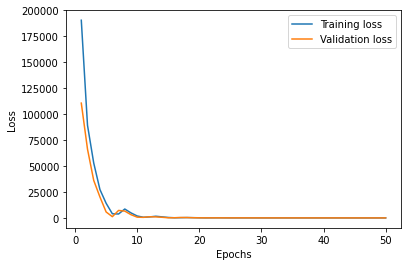

In [11]:
log=trainer.train(train_X, train_y, val_X, val_y, test_X,test_y,list_species,draw_curve=True)